In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Rectangle

In [2]:
# Configure matplotlib
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.size": 14
})

In [3]:
# Load the log file
log_file = 'log_files/logxxxx.log'
data = pd.read_csv(log_file)

# Display the first few rows and columns
print("Columns:", data.columns.tolist())
print("\nFirst few rows:")
data.head()

Columns: ['time', 'x', 'y', 'z', 'yaw', 'ctrl_comp_time', 'rollout_comptime', 'x_ref', 'y_ref', 'z_ref', 'yaw_ref', 'throttle', 'roll_rate', 'pitch_rate', 'yaw_rate', 'save_tube_pyH', 'save_tube_pyL', 'save_tube_pzH', 'save_tube_pzL']

First few rows:


,time,x,y,z,yaw,ctrl_comp_time,rollout_comptime,x_ref,y_ref,z_ref,yaw_ref,throttle,roll_rate,pitch_rate,yaw_rate,save_tube_pyH,save_tube_pyL,save_tube_pzH,save_tube_pzL
0,15.002332,0.077963,3.803949,-12.421936,-0.000288,0.137758,6.0,0.0,3.800152,-12.416646,0.001460,0.581780,-1.0,0.020972,0.016970,3.800076,3.799076,-12.415433,-12.416433
1,15.393789,0.077963,3.803949,-12.421936,-0.000288,0.161739,6.0,0.0,3.800731,-12.416984,-0.008540,0.580447,-1.0,0.052662,0.084833,3.821314,3.789097,-12.404403,-12.408619
2,15.650959,0.096476,3.842526,-12.394568,-0.001855,0.002130,6.0,0.0,3.804553,-12.422613,0.000865,0.582262,-1.0,0.158868,0.294521,3.888226,3.729373,-12.337350,-12.386105
3,15.789447,0.096476,3.842526,-12.394568,-0.001855,0.001207,6.0,0.0,3.843152,-12.395398,-0.003630,0.582067,-1.0,0.351208,0.547260,4.121234,3.493301,-12.098401,-12.466626
4,15.794931,0.096086,3.856189,-12.385160,-0.001037,0.001435,6.0,0.0,3.843778,-12.395852,-0.013630,0.580648,-1.0,0.485846,0.673630,5.420018,2.174935,-10.725863,-13.609906


In [4]:
# Extract relevant data
time = data['time'].values
y = data['y'].values
z = data['z'].values
y_ref = data['y_ref'].values
z_ref = data['z_ref'].values

# Reachable tube bounds
pyH = data['save_tube_pyH'].values  # y upper bound
pyL = data['save_tube_pyL'].values  # y lower bound
pzH = data['save_tube_pzH'].values  # z upper bound
pzL = data['save_tube_pzL'].values  # z lower bound

print(f"Total data points: {len(time)}")
print(f"Time range: {time[0]:.2f} to {time[-1]:.2f} seconds")
print(f"Y range: {np.nanmin(y):.2f} to {np.nanmax(y):.2f}")
print(f"Z range: {np.nanmin(z):.2f} to {np.nanmax(z):.2f}")
print(f"NaN counts - y: {np.isnan(y).sum()}, z: {np.isnan(z).sum()}, pyH: {np.isnan(pyH).sum()}, pyL: {np.isnan(pyL).sum()}, pzH: {np.isnan(pzH).sum()}, pzL: {np.isnan(pzL).sum()}")

Total data points: 5535
Time range: 15.00 to nan seconds
Y range: -0.46 to 3.88
Z range: -12.42 to -1.53
NaN counts - y: 4428, z: 4428, pyH: 0, pyL: 0, pzH: 0, pzL: 0


In [5]:
# Helper function to draw a quad (similar to the original notebook)
def quadplot(ypos, zpos, rot, scale):
    ts = -0.5 * np.arange(np.pi, 3/2 * np.pi, 0.2) + 0.3
    xtemp = np.cos(ts)
    ytemp = np.sin(ts) * np.cos(ts)

    xs = np.hstack((0.4*xtemp - 1, -1, -1, 1, 1, 0.4*xtemp + 1))
    ys = np.hstack((0.3*ytemp + 0.4, 0.4, 0, 0, 0.4, 0.3*ytemp + 0.4))
    xs = scale * xs
    ys = scale * ys
    
    rotmat = np.array([[np.cos(rot), -np.sin(rot)], 
                       [np.sin(rot), np.cos(rot)]])
    newpos = rotmat @ np.vstack((xs, ys))
    xs = newpos[0, :] + ypos
    ys = newpos[1, :] + zpos
    
    return xs, ys

Figure initialized


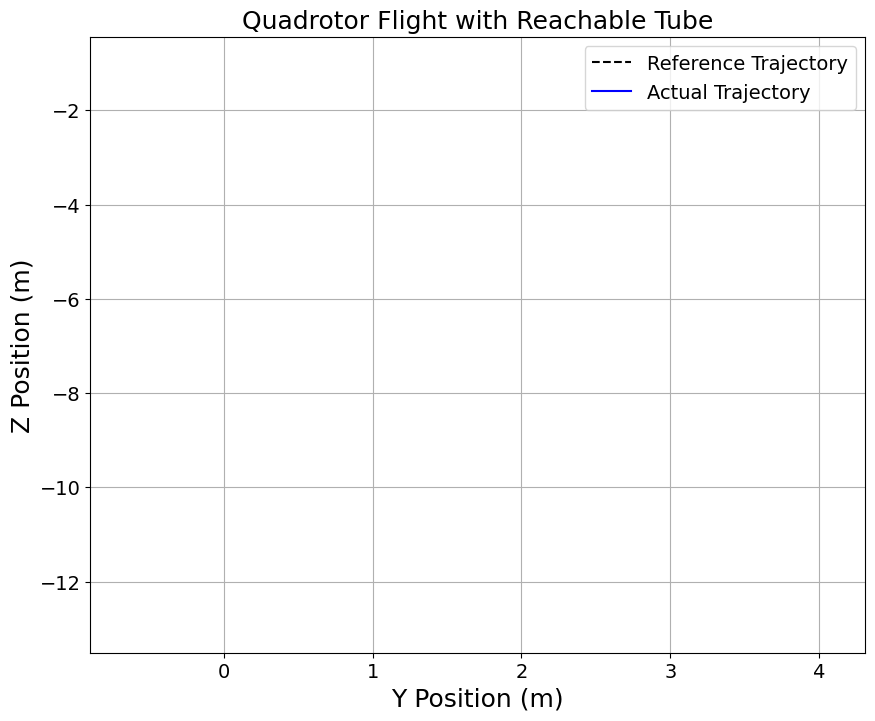

In [6]:
# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

FONTSIZE = 18
LINEWIDTH = 1.5
QUADSIZE = 0.15

# Initialize plot elements
# Reference trajectory (dashed black line)
reference_line, = ax.plot([], [], label='Reference Trajectory', 
                          linestyle='dashed', color='black', linewidth=LINEWIDTH)

# Actual trajectory (solid line)
actual_line, = ax.plot([], [], label='Actual Trajectory', 
                       color='blue', linewidth=LINEWIDTH)

# Reachable tube rectangle
tube_rect = Rectangle((0, 0), 1, 1, linewidth=2, 
                      edgecolor='red', facecolor='none', alpha=0.5)
ax.add_patch(tube_rect)

# Quadrotor representation
quad_line, = ax.plot([], [], color='black', linewidth=LINEWIDTH)

# Set up the plot limits and labels
ax.set_xlabel('Y Position (m)', fontsize=FONTSIZE)
ax.set_ylabel('Z Position (m)', fontsize=FONTSIZE)
ax.set_title('Quadrotor Flight with Reachable Tube', fontsize=FONTSIZE)
ax.legend(loc='upper right', fontsize=FONTSIZE - 4)
ax.grid(True)

# Set axis limits based on data (handle NaNs)
y_margin = (np.nanmax(y) - np.nanmin(y)) * 0.1
z_margin = (np.nanmax(z) - np.nanmin(z)) * 0.1
ax.set_xlim(np.nanmin(y) - y_margin, np.nanmax(y) + y_margin)
ax.set_ylim(np.nanmin(z) - z_margin, np.nanmax(z) + z_margin)

# Time text
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes, 
                    fontsize=FONTSIZE, verticalalignment='top')

print("Figure initialized")

In [7]:
# Animation function
def update(frame):
    # Update reference trajectory up to current frame
    reference_line.set_data(y_ref[:frame+1], z_ref[:frame+1])
    
    # Update actual trajectory up to current frame
    actual_line.set_data(y[:frame+1], z[:frame+1])
    
    # Update reachable tube rectangle (handle NaNs)
    if not (np.isnan(pyH[frame]) or np.isnan(pyL[frame]) or 
            np.isnan(pzH[frame]) or np.isnan(pzL[frame])):
        tube_width = pyH[frame] - pyL[frame]
        tube_height = pzH[frame] - pzL[frame]
        tube_rect.set_xy((pyL[frame], pzL[frame]))
        tube_rect.set_width(tube_width)
        tube_rect.set_height(tube_height)
        tube_rect.set_visible(True)
    else:
        # Hide rectangle if data is NaN
        tube_rect.set_visible(False)
    
    # Update quadrotor position (handle NaNs)
    if not (np.isnan(y[frame]) or np.isnan(z[frame])):
        if 'yaw' in data.columns:
            yaw = data['yaw'].values[frame]
            if np.isnan(yaw):
                yaw = 0
        else:
            yaw = 0
        quad_y, quad_z = quadplot(y[frame], z[frame], yaw, QUADSIZE)
        quad_line.set_data(quad_y, quad_z)
        quad_line.set_visible(True)
    else:
        quad_line.set_visible(False)
    
    # Update time text
    time_text.set_text(f't = {time[frame]:.2f} s')
    
    return reference_line, actual_line, tube_rect, quad_line, time_text

In [8]:
# Create the animation
# Use every Nth frame to speed up the animation (adjust skip_frames as needed)
skip_frames = 5  # Adjust this to control animation speed
frames_to_use = range(0, len(time), skip_frames)

ani = animation.FuncAnimation(fig, update, frames=frames_to_use, 
                             interval=50, blit=True, repeat=True)

plt.tight_layout()
plt.show()

print("Animation created! Close the window to continue.")

<Figure size 640x480 with 0 Axes>

Animation created! Close the window to continue.


In [11]:
# Optional: Save the animation as a GIF
# Uncomment the lines below to save the animation

print("Saving animation...")
ani.save('log_animation.gif', writer='pillow', fps=20)
print("Animation saved as 'log_animation.gif'")

Saving animation...
Animation saved as 'log_animation.gif'


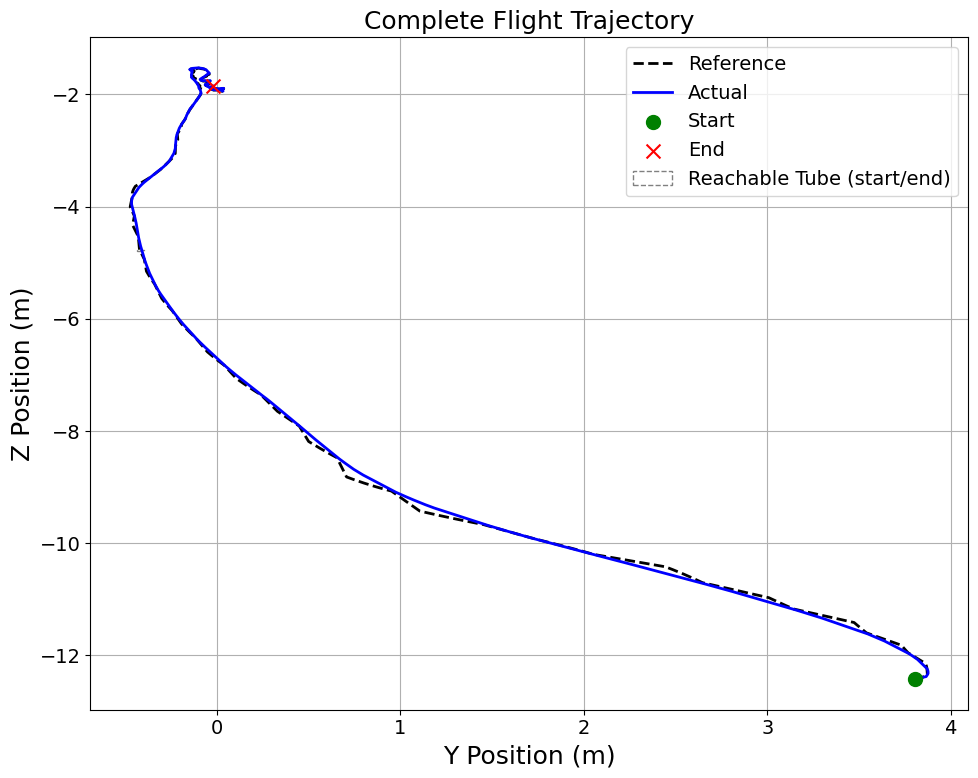

Static plot created!


In [10]:
# Optional: Create a static plot showing the full trajectory
fig2, ax2 = plt.subplots(figsize=(10, 8))

# Plot full trajectories
ax2.plot(y_ref, z_ref, label='Reference', linestyle='dashed', 
         color='black', linewidth=2)
ax2.plot(y, z, label='Actual', color='blue', linewidth=2)

# Plot start and end positions (handle NaNs)
# Find first non-NaN values
start_idx = 0
for i in range(len(y)):
    if not (np.isnan(y[i]) or np.isnan(z[i])):
        start_idx = i
        break

# Find last non-NaN values
end_idx = len(y) - 1
for i in range(len(y) - 1, -1, -1):
    if not (np.isnan(y[i]) or np.isnan(z[i])):
        end_idx = i
        break

ax2.scatter(y[start_idx], z[start_idx], color='green', s=100, 
           marker='o', label='Start', zorder=5)
ax2.scatter(y[end_idx], z[end_idx], color='red', s=100, 
           marker='x', label='End', zorder=5)

# Plot reachable tube at start and end (if not NaN)
if not (np.isnan(pyL[start_idx]) or np.isnan(pzL[start_idx]) or 
        np.isnan(pyH[start_idx]) or np.isnan(pzH[start_idx])):
    start_rect = Rectangle((pyL[start_idx], pzL[start_idx]), 
                           pyH[start_idx] - pyL[start_idx], 
                           pzH[start_idx] - pzL[start_idx],
                           linewidth=1, edgecolor='gray', facecolor='none', 
                           linestyle='--', label='Reachable Tube (start/end)')
    ax2.add_patch(start_rect)

if not (np.isnan(pyL[end_idx]) or np.isnan(pzL[end_idx]) or 
        np.isnan(pyH[end_idx]) or np.isnan(pzH[end_idx])):
    end_rect = Rectangle((pyL[end_idx], pzL[end_idx]), 
                         pyH[end_idx] - pyL[end_idx], 
                         pzH[end_idx] - pzL[end_idx],
                         linewidth=1, edgecolor='gray', facecolor='none', linestyle='--')
    ax2.add_patch(end_rect)

ax2.set_xlabel('Y Position (m)', fontsize=FONTSIZE)
ax2.set_ylabel('Z Position (m)', fontsize=FONTSIZE)
ax2.set_title('Complete Flight Trajectory', fontsize=FONTSIZE)
ax2.legend(fontsize=FONTSIZE - 4)
ax2.grid(True)

plt.tight_layout()
plt.show()

print("Static plot created!")